# Eigenmodes of Shallow Water Equations

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
from mpi4py import MPI
CW = MPI.COMM_WORLD
import logging
logger = logging.getLogger(__name__)
import matplotlib
%matplotlib inline
import os

In [20]:
### Simulation Parameters

Nx = 64 #64
Ny = 128 #128
Ly = 20*np.pi
Lx = 10
y0 = Ly/4

# Alpha
alpha = 1.2
f0 = 1
kmax = np.pi # horizontal wave number extrema
kx_global = np.linspace(-kmax,kmax,100)

ky = 0.0
N = 1

def problem_builder(kx):
    # Create bases and domain
    ycoord = d3.Coordinate('y')
    dist = d3.Distributor(ycoord, dtype=np.complex128)
    ybasis = d3.ComplexFourier(ycoord, size=Ny, bounds=(-Ly/2, Ly/2))
    y = dist.local_grids(ybasis) # grid

    # Fields 
    u = dist.Field(name='u', bases=ybasis)
    v = dist.Field(name='v', bases=ybasis)
    h = dist.Field(name='h', bases=ybasis)
    # tau_1 = dist.Field(name='tau_1')
    # tau_2 = dist.Field(name='tau_2')
    omega = dist.Field(name='omega')

    # Substitution 
    dy = lambda A: d3.Differentiate(A, ycoord)
    dx = lambda A: 1j*kx*A
    dt = lambda A: -1j*omega*A
    # lift_basis = ybasis.derivative_basis(1)
    # lift = lambda A: d3.Lift(A, lift_basis, -1)
    #lift = lambda A: d3.Lift(A, ybasis, -1)
    ky = 1

    # define non-constant coefficients
    f = dist.Field(bases=ybasis)
    # f['g'] = f0*np.sin(2*np.pi*y[0]/Ly)
    f['g'] = f0*(np.tanh(alpha*(y[0]-y0)) -np.tanh(alpha*(y[0]+y0)) +1)

    problem = d3.EVP([u, v, h], eigenvalue=omega, namespace=locals())

    problem.add_equation("dt(u) + dx(h) - f * v = 0")
    problem.add_equation("dt(v) + dy(h) + f * u = 0")
    problem.add_equation("dt(h) + dx(u) + dy(v) = 0")
    #problem.add_equation("integ(h) = 0")
    #problem.add_equation("integ(v) = 0")

#   periodic boundary condition
    # problem.add_equation("v(y='left') - v(y='right') = 0")
    # problem.add_equation("u(y='left') - u(y='right') = 0")
     #problem.add_equation("v(y='right') = 0")

    solver = problem.build_solver()
    return solver, ybasis, dist

In [21]:
#this is the function computing the spectrum for a given horizontal wavenumber kx
def make_array_omega(kx):
    logger.info('Computing array of omega values at kx = %f' %kx)
    # Change kx parameter
    solver, ybasis, dist = problem_builder(kx)
    solver.solve_dense(solver.subproblems[0])
    evals = np.sort(solver.eigenvalues)
   
    return evals

In [23]:
# compute spectrum
omega = np.array([make_array_omega(kx) for kx in kx_global])

2025-10-21 08:48:27,925 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.141593
2025-10-21 08:48:27,997 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s
2025-10-21 08:48:28,933 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.078126
2025-10-21 08:48:28,984 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2025-10-21 08:48:29,912 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.014660
2025-10-21 08:48:29,962 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2025-10-21 08:48:30,917 __main__ 0/1 INFO :: Computing array of omega values at kx = -2.951193
2025-10-21 08:48:30,972 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2025-10-21 08:48:31,932 __main__ 0/1 INFO :: Computing array of omega values at kx = -2.8877

In [24]:
# compute the localization
def make_loc(kx):
    logger.info('Computing array of omega values at kx = %f' %kx)
    # Change kx parameter
    solver, ybasis, dist = problem_builder(kx)
    # y = dist.local_grids(ybasis)[0] 
    solver.solve_dense(solver.subproblems[0])
    
    order = np.argsort(solver.eigenvalues.real)
    evals = np.sort(solver.eigenvalues)
    solver.eigenvalues = evals
    solver.eigenvectors = solver.eigenvectors[:, order]
    
    # define new fields for localization
    loc=np.zeros(order.size)
    for iorder in np.arange(order.size):
        solver.set_state(iorder,solver.subsystems[0])
        umode = solver.state[0]['g'] # find the first field 
        norm = umode * umode.conjugate()
        normf = dist.Field(name='normf', bases=ybasis)
        normf['g'] = norm.real
        
        normy = np.sin(2*np.pi*dist.local_grids(ybasis)[0]/Ly) * norm  # PBCs
        # normy = (1.0 - np.fabs(4.0*y/Ly)) * norm # Dirichlet
        # normy = np.sin(2.0*np.pi*y_basis.grid(scale=1)/Ly) * norm # Dirichlet
        
        normyf = dist.Field(name='normyf', bases=ybasis)
        normyf['g'] = normy.real
        loc[iorder]= d3.Integrate(normyf).evaluate()['g'][0].real/d3.Integrate(normf).evaluate()['g'][0].real
    
    return loc

loc_real = np.array([make_loc(kx) for kx in kx_global])
kx_real =np.array([kx*np.ones(omega.shape[1]) for kx in kx_global])

2025-10-21 08:50:07,447 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.141593
2025-10-21 08:50:07,507 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+01/s
2025-10-21 08:50:08,568 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.078126
2025-10-21 08:50:08,617 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2025-10-21 08:50:09,660 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.014660
2025-10-21 08:50:09,709 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2025-10-21 08:50:10,759 __main__ 0/1 INFO :: Computing array of omega values at kx = -2.951193
2025-10-21 08:50:10,808 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2025-10-21 08:50:11,883 __main__ 0/1 INFO :: Computing array of omega values at kx = -2.8877

In [25]:
loc_real

array([[ 0.48071429, -0.18986226, -0.1822097 , ...,  0.1822097 ,
         0.18986226, -0.48071429],
       [ 0.47449848, -0.19329819, -0.18547701, ...,  0.18547701,
         0.19329819, -0.47449848],
       [ 0.46811953, -0.19685968, -0.188862  , ...,  0.188862  ,
         0.19685968, -0.46811953],
       ...,
       [-0.46811953,  0.19685968,  0.188862  , ..., -0.188862  ,
        -0.19685968,  0.46811953],
       [-0.47449848,  0.19329819,  0.18547701, ..., -0.18547701,
        -0.19329819,  0.47449848],
       [-0.48071429,  0.18986226,  0.1822097 , ..., -0.1822097 ,
        -0.18986226,  0.48071429]], shape=(100, 384))

<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
/var/folders/76/6wfqn2mn7p57w925khjfdt800000gn/T/ipykernel_96700/3891547728.py:15: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega$')


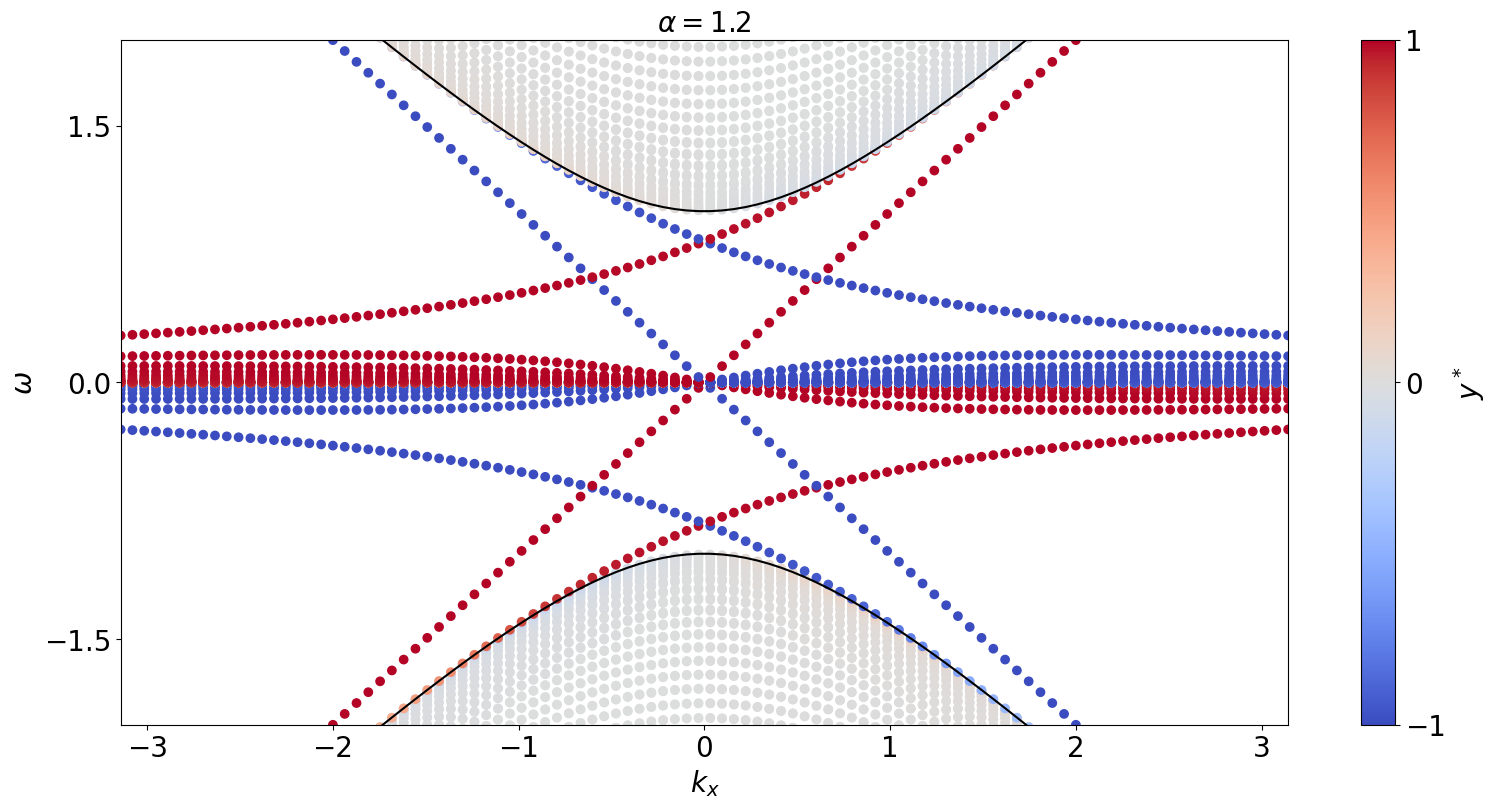

In [29]:
# plot the spectrum 
fig, ax = plt.subplots(figsize=(16, 8))

ylim = np.array([-1., 1.])*2
plt.ylim(ylim)

# ky_local=2*np.pi/(Ly)*(np.array([0]))

# Plot the analytical shallow water spectrum for f = 1
kx=kx_global
om = ( kx**2 + 1)**0.5
im = ax.plot(kx_global,om,color='black')
im = ax.plot(kx_global,-om,color='black')
plt.xlabel('$k_x$')
plt.ylabel('$\omega$') 
    
# plot the real part of the spectrum
im = ax.scatter(kx_real, omega.real, c=loc_real, cmap=plt.cm.coolwarm, vmin=-1, vmax=1)
cbar=fig.colorbar(im, ax=ax, ticks=[-1.0,0.0,1.0])
cbar.ax.tick_params(labelsize=20)
cbar.set_label('$y^*$', size=20)

ax.set_xticks([-3, -2, -1, 0, 1, 2, 3,])
ax.set_yticks([ -1.5, 0, 1.5])
# ax.set_yticks([-np.min(ylim), 0, np.max(ylim)])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    plt.tight_layout()

plt.xlim([np.min(kx_global), np.max(kx_global)])
plt.title(f'$\\alpha = ${alpha}', fontsize = 20)


masterdir = os.getcwd()

# plt.title('$U_0 = ' + str(U0) + '$')

# plt.show()
# fig.savefig(masterdir + '/fig_prelim/primitive/PE-real_kz_' + str(kz) + '_N' + str(N) + '_U_' + str(U0) + '_Ly_' + str(Ly) + '.pdf', format='pdf', dpi=fig.dpi)
# # fig.savefig(masterdir + '/fig_prelim/PE-real_kz_' + str(kz) + '_N' + str(N) + '_U_' + str(U0) + '_Ly_' + str(Ly) + '.eps', dpi=fig.dpi)

# np.savetxt(os.getcwd() + '/data/primitive/evals_numerical_kz_' + str(round(kz,3)) + '_U_' + str(U0) + '_Ly_' + str(Ly) + '.txt', omega.real)
